# Question 3 - Identify Relationship between the Building Characteristics and the Top Complaint Type

The goal of this exercise is to find the answer to the third question of the problem statement: 

*Does the Complaint Type you identified in response to Question 1 have an apparent relationship with any particular characteristic or characteristics of the houses?*

<br>

# Introduction

Again, we start by importing the necessary libraries and loading the two datasets.

## Libraries

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd

from scipy import stats
import missingno as msno

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%config InlineBackend.figure_format = 'retina'

C:\Users\ko40\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Data

### 311 Complaint Dataset

In [2]:
columns = ['Created Date', 'Unique Key', 'Complaint Type', 'Incident Zip', 'Incident Address', 'Street Name',
           'Address Type', 'City', 'Resolution Description', 'Borough', 'Latitude', 'Longitude', 'Closed Date', 
           'Location Type', 'Status']

df_311 = pd.read_csv('311_Service_Requests_from_2010_to_Present_min.csv', 
                     nrows = 1E+7, 
                     usecols = columns, 
                     parse_dates = ['Created Date', 'Closed Date'])

df_311_raw = df_311.copy()

df_311['Complaint Type'] = np.where(df_311['Complaint Type'] == 'HEATING','HEAT/HOT WATER', df_311['Complaint Type'])

We need to focus on the borough with the highest number of 'HEAT/HOT WATER' reports, i.e. the Bronx. Therefore, we will create a new DataFrame containing only BRONX samples and with 'HEAT/HOT WATER' as the complaint type.

In [3]:
df_311_BX = df_311[(df_311['Complaint Type'] == 'HEAT/HOT WATER') & (df_311['Borough'] == 'BRONX')].reset_index(drop = True)

### PLUTO Dataset for Housing

For this exercise, we also need to import the PLUTO dataset for the Bronx. 

In [4]:
columns = ['Address', 'BldgArea', 'BldgDepth', 'BuiltFAR', 'CommFAR', 'FacilFAR', 'Lot', 'LotArea', 'LotDepth', 
           'NumBldgs', 'NumFloors', 'OfficeArea', 'ResArea', 'ResidFAR', 'RetailArea', 'YearBuilt', 'YearAlter1', 
           'ZipCode', 'YCoord', 'XCoord']

df_pluto_BX = pd.read_csv('BX_18v1.csv', usecols = columns)
df_pluto_BX.head()

,Lot,ZipCode,Address,LotArea,BldgArea,ResArea,OfficeArea,RetailArea,NumBldgs,NumFloors,LotDepth,BldgDepth,YearBuilt,YearAlter1,BuiltFAR,ResidFAR,CommFAR,FacilFAR,XCoord,YCoord
0,1,10454.0,122 BRUCKNER BOULEVARD,15000,0,0,0,0,1,0.0,200.0,0.0,0,0,0.00,6.02,5.0,6.5,1005957.0,232162.0
1,4,10454.0,126 BRUCKNER BOULEVARD,13770,752,0,272,0,2,1.0,100.0,16.0,1931,1994,0.05,6.02,5.0,6.5,1006076.0,232156.0
2,10,10454.0,138 BRUCKNER BOULEVARD,35000,39375,0,0,0,1,2.0,200.0,200.0,1931,0,1.13,6.02,5.0,6.5,1006187.0,232036.0
3,17,10454.0,144 BRUCKNER BOULEVARD,2500,12500,12500,0,0,1,5.0,100.0,85.0,1931,2001,5.00,6.02,5.0,6.5,1006299.0,232033.0
4,18,10454.0,148 BRUCKNER BOULEVARD,1875,8595,6876,0,1719,1,5.0,75.0,70.0,1920,2009,4.58,6.02,5.0,6.5,1006363.0,232040.0


# Merging the two Datasets

At this stage, we need to **merge** the two datasets into one. I chose to merge them based on an instance’s address.

We can use the `groupby()` method on the 311 Dataset to create a dataset with the total number of complaints about each address. We first need to drop all rows with a missing address. 

In [5]:
df_311_BX.dropna(subset = ['Incident Address'], axis = 0, inplace = True)  # drop rows with missing values
print('311 Dataset: Rows with a missing address dropped successfully!')

df_311_total = df_311_BX.groupby('Incident Address').agg('count')['Borough'].to_frame()
df_311_total.columns = ['Complaints #']

print('New 311 Dataset: {} rows'.format(df_311_total.shape[0]))
df_311_total.head()

311 Dataset: Rows with a missing address dropped successfully!
New 311 Dataset: 22859 rows


,Complaints #
Incident Address,
1 ADRIAN AVENUE,39
1 CAROLL STREET,18
1 DOROTHEA PLACE,1
1 EARHART LANE,2
1 EAST 169 STREET,1


The PLUTO dataset also contains missing values for 'Address'.

In [6]:
print('{} missing addresses in the PLUTO dataset'.format(df_pluto_BX['Address'].isnull().sum()))

df_pluto_BX.dropna(subset = ['Address'], axis = 0, inplace = True)
print('PLUTO Dataset: Rows with a missing address dropped successfully!')

69 missing addresses in the PLUTO dataset
PLUTO Dataset: Rows with a missing address dropped successfully!


Apart from missing values, we also need to check if there are duplicate entries for the same address.

In [7]:
df_pluto_BX['Address'].value_counts() 

SHORE DRIVE               42
PALISADE AVENUE           37
WHITE PLAINS ROAD         35
PARK AVENUE               35
BRUCKNER BOULEVARD        34
                          ..
3481 BOSTON ROAD           1
4127 MONTICELLO AVENUE     1
3817 3 AVENUE              1
2739 MORGAN AVENUE         1
2115 WALTON AVENUE         1
Name: Address, Length: 87017, dtype: int64

There are indeed duplicate addresses. We need to remove them before proceeding. 

In [8]:
df_pluto_BX.drop_duplicates(subset = 'Address', keep = 'first', inplace = True)

print('PLUTO Dataset: Duplicate addresses dropped successfully!')
print('New PLUTO Dataset: {} rows x {} columns'.format(df_pluto_BX.shape[0], df_pluto_BX.shape[1]))

PLUTO Dataset: Duplicate addresses dropped successfully!
New PLUTO Dataset: 87017 rows x 20 columns


<br>

The two datasets have a different number of rows. Since the PLUTO dataset has more entries/addresses (87017 compared to only 22859 for the 311 Dataset), some rows will contain NaN values for the 'Complaints #' column. 

We are now ready to merge the two datasets:

In [9]:
df_merged = pd.merge(df_311_total, df_pluto_BX, right_on = 'Address', left_index = True, how = 'right')

print('The merged dataset has {} rows x {} columns.'.format(df_merged.shape[0], df_merged.shape[1]))
df_merged.head()

The merged dataset has 87017 rows x 21 columns.


,Complaints #,Lot,ZipCode,Address,LotArea,BldgArea,ResArea,OfficeArea,RetailArea,NumBldgs,...,LotDepth,BldgDepth,YearBuilt,YearAlter1,BuiltFAR,ResidFAR,CommFAR,FacilFAR,XCoord,YCoord
0,NaN,1,10454.0,122 BRUCKNER BOULEVARD,15000,0,0,0,0,1,...,200.0,0.0,0,0,0.00,6.02,5.0,6.5,1005957.0,232162.0
1,NaN,4,10454.0,126 BRUCKNER BOULEVARD,13770,752,0,272,0,2,...,100.0,16.0,1931,1994,0.05,6.02,5.0,6.5,1006076.0,232156.0
2,NaN,10,10454.0,138 BRUCKNER BOULEVARD,35000,39375,0,0,0,1,...,200.0,200.0,1931,0,1.13,6.02,5.0,6.5,1006187.0,232036.0
3,5.0,17,10454.0,144 BRUCKNER BOULEVARD,2500,12500,12500,0,0,1,...,100.0,85.0,1931,2001,5.00,6.02,5.0,6.5,1006299.0,232033.0
4,13.0,18,10454.0,148 BRUCKNER BOULEVARD,1875,8595,6876,0,1719,1,...,75.0,70.0,1920,2009,4.58,6.02,5.0,6.5,1006363.0,232040.0


We will save the merged dataset as a separate CSV file and use it for the final problem.

In [10]:
df_merged.to_csv('Merged_dataset.csv')

# Looking for Correlations

Let’s look at how much each attribute correlates with the number of complaints. 

## Pearson’s Correlation

We will initially use Pearson’s correlation which measures linear correlations.

In [11]:
corr_p = df_merged.corr()['Complaints #'].sort_values(ascending = False)

display(corr_p.to_frame().style.background_gradient(cmap = 'Reds', axis = 0))

,Complaints #
Complaints #,1.000000
NumFloors,0.241584
BldgDepth,0.194447
BuiltFAR,0.157420
ResidFAR,0.149474
ResArea,0.140688
FacilFAR,0.133405
BldgArea,0.124686
LotDepth,0.073788
YearAlter1,0.058181


We notice only a **weak positive linear correlation** (absolute correlation coefficient ~ 0.20) with **two features**: 'NumFloors' and 'BldgDepth'.


## Spearman’s Correlation

After a post in the discussion section, I also decided to use Spearman's correlation coefficient. It assesses how well the relationship between two variables can be described using a monotonic function.

In [12]:
corr_sp = df_merged.corr(method = 'spearman')['Complaints #'].sort_values(ascending = False)

display(corr_sp.to_frame().style.background_gradient(cmap = 'Reds', axis = 0))

,Complaints #
Complaints #,1.000000
ResArea,0.608828
NumFloors,0.574655
BuiltFAR,0.573750
BldgArea,0.566010
BldgDepth,0.487732
LotArea,0.431083
ResidFAR,0.334257
FacilFAR,0.311694
YearAlter1,0.171683


The total number of 'HEAT/HOT WATER' complaints has a **moderate positive correlation** (absolute correlation coefficient between 0.40 - 0.59) with **6 features**: 'ResArea', 'NumFloors', 'BuiltFAR', 'BldgArea', 'BldgDepth', 'LotArea'. It's not a surprise that these features are related to spatial dimensions.

All other features show a weak correlation (0.2 - 0.39) or a very week correlation (0-0.19). 

We can confirm that our results are statistically significant by calculating the p-value for each feature.

In [13]:
# delete rows with NaN values 
df_merged_ = df_merged.dropna(subset = ['Complaints #'], axis = 0)

# create a new dataframe for storing the results
df_merged_stats = pd.DataFrame(columns = df_merged_.columns[1:], 
                               index = ['Correlation', 'P-value'])

# iterate over all columns, calculate Spearman's coefficient and the p-value
for i in df_merged_stats.columns:
    spearman, p_value = stats.spearmanr(df_merged_['Complaints #'], df_merged_[i])
    df_merged_stats[i]['Correlation'] = spearman
    df_merged_stats[i]['P-value'] = p_value
    
df_merged_stats.T.sort_values(by = 'Correlation', ascending = False)

C:\Users\ko40\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:248: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


,Correlation,P-value
ResArea,0.608828,0
NumFloors,0.574655,0
BuiltFAR,0.57375,0
BldgArea,0.56601,0
BldgDepth,0.487732,0
LotArea,0.431083,0
ResidFAR,0.334257,0
FacilFAR,0.311694,0
YearAlter1,0.171683,8.59105e-115
RetailArea,0.131621,7.61611e-68


For the sake of completeness, we can check for correlations between every possible pair of features by plotting a heatmap:

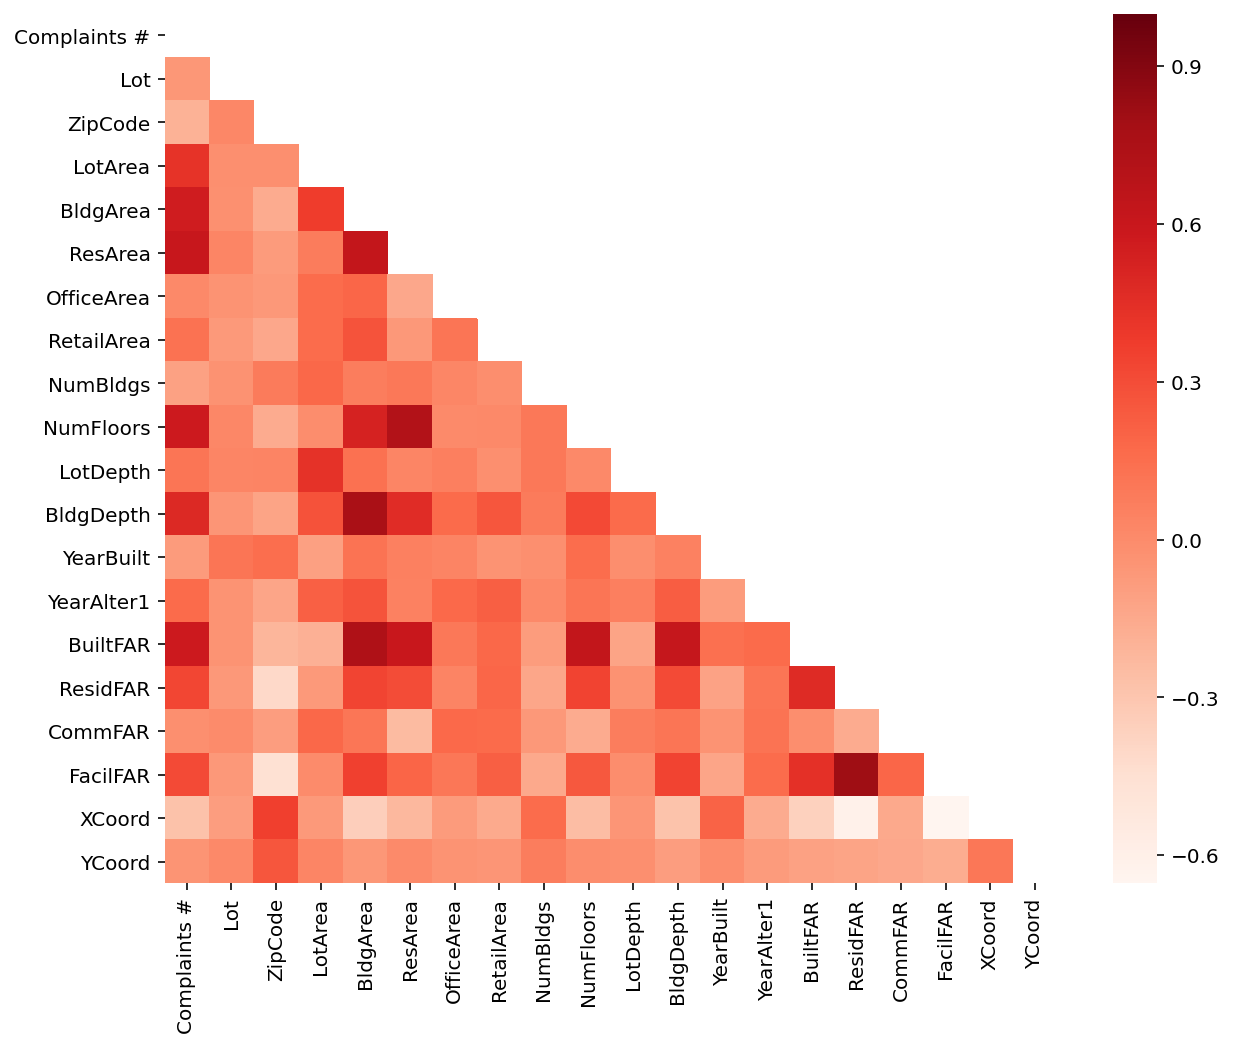

In [14]:
corr_table = df_merged.corr(method = 'spearman')

plt.figure(figsize = (10, 8))

mask = np.triu(np.ones_like(corr_table, dtype = np.bool))
ax = sns.heatmap(corr_table, mask = mask, cmap = 'Reds')

<br>

# Conclusions

- Using **Spearman's correlation coefficient**, we showed that the total number of 'HEAT/HOT WATER' complaints displays a **moderate positive correlation** with **six features** ('ResArea', 'NumFloors', 'BuiltFAR', 'BldgArea', 'BldgDepth', and 'LotArea').
- Only **two** of these features ('NumFloors' and 'BldgDepth') show a **weak linear correlation** measured by **Pearson’s correlation coefficient**. The remaining four exhibit a very weak linear correlation.

<br>

---

# Quiz

## Question 1

Can you determine the age of a building from the PLUTO dataset?

Answer: Yes, a building's age can be determined using the 'YearBuilt' column of PLUTO dataset.

In [15]:
df_merged['Age'] = 2021 - df_merged['YearBuilt']
df_merged[['Address', 'YearBuilt', 'Age']].sample(5)

,Address,YearBuilt,Age
80640,249 KEARNEY AVENUE,1960,61
24933,200 EAST 205 STREET,1941,80
76985,3161 RAWLINS AVENUE,1925,96
78311,210 OUTLOOK AVENUE,2002,19
58779,1017 EAST 215 STREET,1910,111


## Question 2

Which of the following methodologies can you use to identify whether any relationship exists between the building characteristics and the number of complaints?

- Pearson Correlation
- Feature Importance function from Random Forest Algorithm
- Feature Importance function from XGBoost Algorithm
- None of the 3 methods
- All of the 3 methods

Answer: All of the 3 methods. - **Note**: We will analyse feature importance in the next notebook.

## Question 3

The cardinality of the data in PLUTO dataset is at the same level as the complaint dataset?

Answer: False. The 311 Dataset has multiple entries for the same address. On the other hand, the PLUTO dataset has one entry for each address.